### Import modules

In [1]:
import sys
import os
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

utils_path = os.path.abspath(os.path.join('..', 'utils'))
sys.path.append(utils_path)

from dslabs_functions import ts_aggregation_by, series_train_test_split, plot_forecasting_eval, plot_forecasting_series

#### Load data

In [2]:
data_path = os.path.abspath(os.path.join('..','..', 'data/f_s_forecast_ny_arrests.csv'))

def load_data(data_path):
    data: DataFrame = read_csv(
        data_path,
        index_col="Date",
        sep=";",
        decimal=".",
        parse_dates=True,
        infer_datetime_format=True,
    )
    return data

data = load_data(data_path)
file_tag = "ARREST"
target = "Manhattan"

data = data[[target]]

### Preparation

In [ ]:
def data_preparation(data):
    # Missing value 
    data: DataFrame = data.dropna(how="any", inplace=False) 

    # Train/test split
    train, test = series_train_test_split(data)   

    # Convert Series to DataFrame
    if isinstance(train, pd.Series):
        train = train.to_frame()
    if isinstance(test, pd.Series):
        test = test.to_frame()

    # Scaling
    transf: MinMaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True).fit(train)
    train_scaled = DataFrame(transf.transform(train), index=train.index, columns=train.columns)
    test_scaled = DataFrame(transf.transform(test), index=test.index, columns=test.columns)

    # # Aggregation
    # train_agg_week: DataFrame = ts_aggregation_by(train_scaled, gran_level="W", agg_func="sum")
    # test_agg_week: DataFrame = ts_aggregation_by(test_scaled, gran_level="W", agg_func="sum")
    # agg_df_month: DataFrame = ts_aggregation_by(series, gran_level="M", agg_func="sum")
    # agg_df_quarter: DataFrame = ts_aggregation_by(series, gran_level="Q", agg_func="sum")   

    # Smoothing
    WIN_SIZE = 10
    train_smooth: Series = train_scaled.rolling(window=WIN_SIZE).mean()
    train_smooth = train_smooth.dropna()

    # Differentiation
    train_diff: Series = train_smooth.diff()
    train_diff = train_diff.dropna()
    test_diff: Series = test_scaled.diff()
    test_diff = test_diff.dropna()

    # train_diff: Series = train_diff.diff()
    # train_diff = train_diff.dropna()
    # test_diff: Series = test_diff.diff()
    # test_diff = test_diff.dropna()

    return train_diff, test_diff
    
    
train, test = data_preparation(data)

print(train)
print(test)

            Manhattan
Date                 
2006-01-12   0.003960
2006-01-13  -0.016436
2006-01-14  -0.039406
2006-01-15  -0.027525
2006-01-16   0.017426
...               ...
2020-05-21  -0.001386
2020-05-22  -0.018416
2020-05-23  -0.002574
2020-05-24  -0.008317
2020-05-25   0.011881

[5248 rows x 1 columns]
            Manhattan
Date                 
2020-05-28  -0.287129
2020-05-29   0.043564
2020-05-30   0.200000
2020-05-31  -0.227723
2020-06-01   1.071287
...               ...
2021-12-27  -0.057426
2021-12-28   0.029703
2021-12-29  -0.005941
2021-12-30  -0.063366
2021-12-31   0.035644

[583 rows x 1 columns]


#### Linear Regression

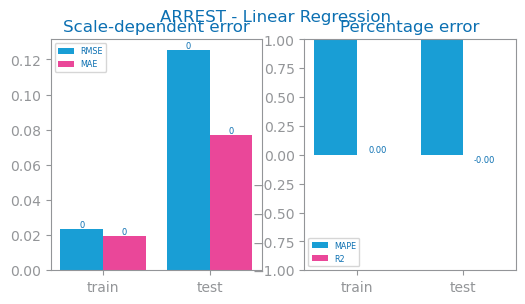

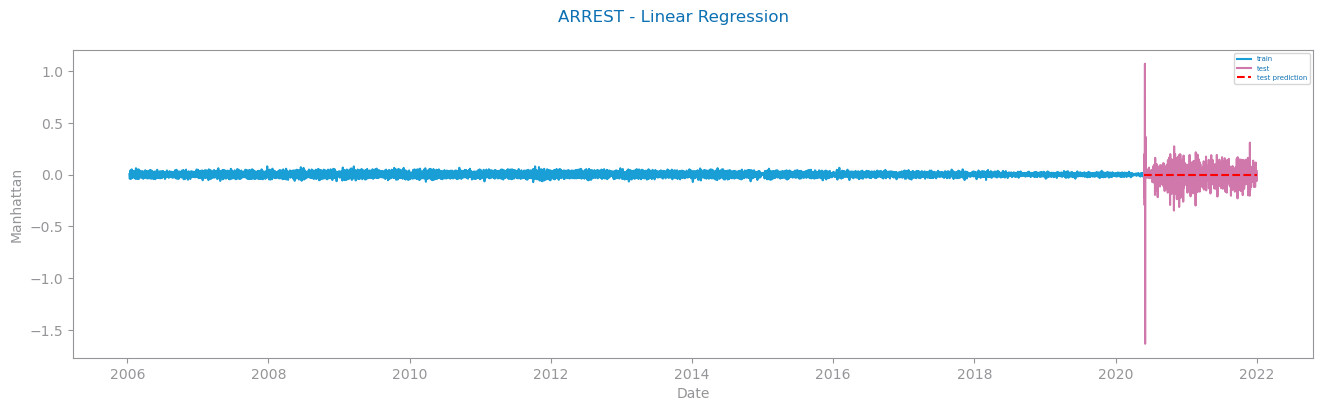

In [4]:
trnX = arange(len(train)).reshape(-1, 1)
trnY = train.values.ravel()
tstX = arange(len(train), len(train)+len(test)).reshape(-1, 1)
tstY = test.values.ravel()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}_linear_regression_eval.png")

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel="Date",
    ylabel=target,
)
savefig(f"images/{file_tag}_linear_regression_forecast.png")